# Simple forecast of a crypto currency

This notebook tries to use simple forecast methods and calculate their error.

The time series is only predicted one step into the future.
This is done for all possible past time series and the error over the prediction is calculated.

Therefore, no test data is needed. For any given time in the series, the prediction is a function of some or all past values in the series:

$$t_n = f(t_{n-1}, t_{n-2}, ..., t_0)$$

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error
import math

from sklearn.linear_model import LinearRegression

## Import code from *data preprocessing* notebook

In [2]:
import ipynb.fs  # Boilerplate required
# only import defnitions
from .defs.data_preprocessing import loadCoinMarketCap

In [3]:
matplotlib.rcParams['figure.figsize'] = 15,6

## Load historical data into a dataframe

In [4]:
df = loadCoinMarketCap(
    minSamples   = 180, # only consider coins having at least half a year of samples
    minMarketCap = 1*1000*1000*1000, # 1 billion
    minVolume    = 1*1000*1000*1000, # 1 billion
)
# some constants
COL_VOLUME = "volume"
COL_MARKET = "marketcap"
COL_NAME   = "name"
COL_OPEN   = "open"
COL_CLOSE  = "close"
COL_HIGH   = "high"
COL_LOW    = "low"
print(df.head())
print("Currencies: {}".format(", ".join(df[COL_NAME].unique())))

Samples filled: 5
Loaded 13 currencies, 10727 samples.
               slug name    open    high     low   close  volume     marketcap
date                                                                          
2013-04-28  bitcoin  BTC  135.30  135.98  132.10  134.21     0.0  1.500520e+09
2013-04-29  bitcoin  BTC  134.44  147.49  134.00  144.54     0.0  1.491160e+09
2013-04-30  bitcoin  BTC  144.00  146.93  134.05  139.00     0.0  1.597780e+09
2013-05-01  bitcoin  BTC  139.00  139.89  107.72  116.99     0.0  1.542820e+09
2013-05-02  bitcoin  BTC  116.38  125.60   92.28  105.21     0.0  1.292190e+09
Currencies: BTC, ETH, XRP, BCH, LTC, XLM, NEO, MIOTA, ETC, QTUM, EOS, USDT, SNT


## Select a currency to work on

In [5]:
currency = "ETH"
lookAhead = 1  # step to predict into future
lookBack = 30  # steps to look back (if needed)

Scale functions

In [6]:
# def scale(ts):
#     return np.log(ts)
# def invScale(ts):
#     return np.exp(ts)

scale = lambda ts: ts
invScale = lambda ts: ts

count     922.000000
mean      141.810856
std       256.028958
min         0.434829
25%         7.872500
50%        11.985000
75%       230.745000
max      1396.420000
Name: ETH, dtype: float64


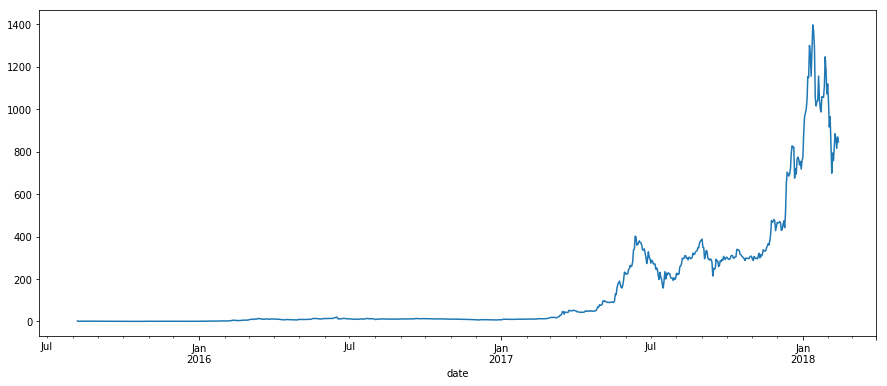

In [7]:
dfCoin = df.loc[df[COL_NAME] == currency]
# only keep close column
sCoin = dfCoin[COL_CLOSE]
sCoin.name = currency
sCoin.plot()
print(sCoin.describe())
sCoin = scale(sCoin)
invScale(sCoin)
pass

## Forecast time serie

In [8]:
def plotFc(title, series, pred):
    series, pred = invScale(series), invScale(pred)
    samples = min(30, len(series))
    rmse = math.sqrt(mean_squared_error(series, pred))
    plt.plot(series[-samples:], label="series", color="blue")
    plt.plot(pred[-samples:], label="forecast", color="red")
    plt.legend(loc="best")    
    plt.title("{} (RMSE: {:0.2f})".format(title, rmse))
    plt.show()

### Using latest sample

Predict the next sample based on the latest sample.

$$ t_n = t_{n-1} $$

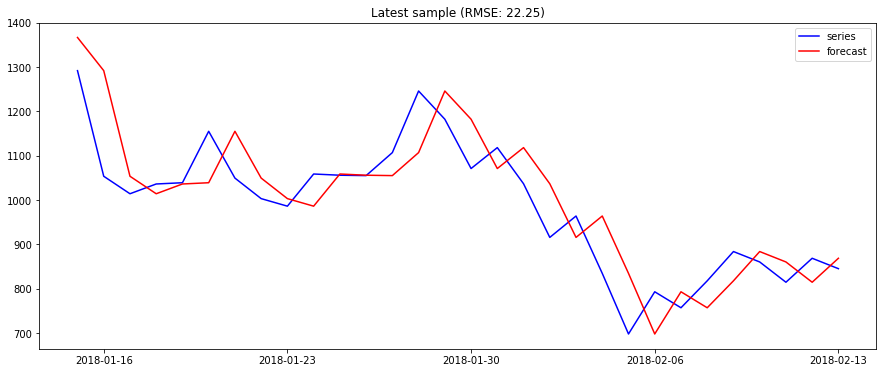

In [9]:
# shift the time sereis look ahead steps into future
yHat = sCoin.shift(lookAhead)
# ignore the first value
plotFc("Latest sample", sCoin[1:], yHat[1:])

### Using average up to latest sample

Use the mean/average of all known samples up to *n*.

$$ t_n = \frac{1}{k} \sum_{k=1}^{n-1} t_k$$

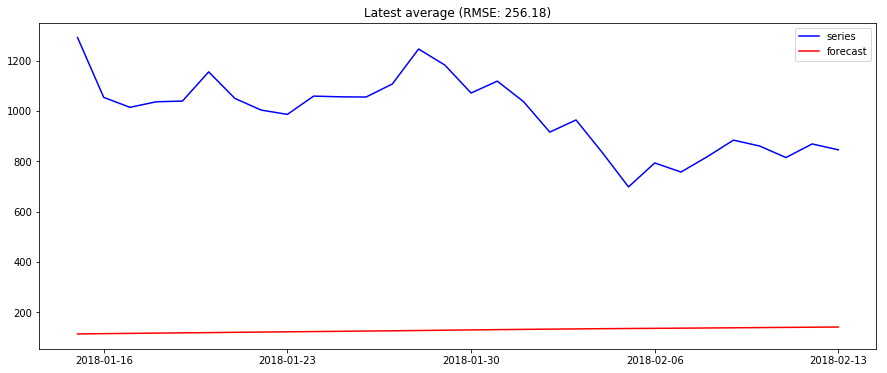

In [10]:
yHat = []
for k in range(len(sCoin) - lookAhead):
    mean = sCoin[:k+lookAhead].mean()
    yHat.append(mean)
yHat = pd.Series(yHat, index=sCoin.index[lookAhead:])
# ignore the first value
plotFc("Latest average", sCoin[lookAhead:], yHat)

### Simple moving average over latest samples

Use the mean/average over the latest *m* samples for any *n*.

$$ t_n = \frac{1}{k} \sum_{k=n-m}^{n-1} t_k,
m = lookBack $$

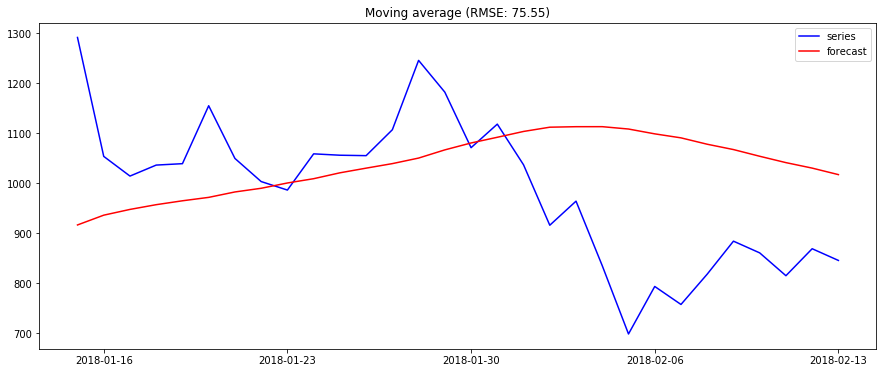

In [11]:
yHat = []
for k in range(lookBack, len(sCoin) - lookAhead):
    mean = sCoin[k-lookBack:k+lookAhead].mean()
    yHat.append(mean)
yHat = pd.Series(yHat, index=sCoin.index[lookBack+lookAhead:])
# ignore the first value
plotFc("Moving average", sCoin[lookBack+lookAhead:], yHat)

### Exponential weighted moving average


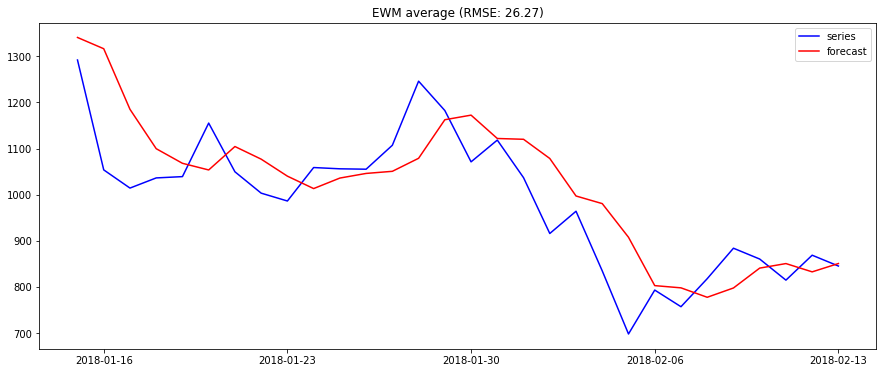

In [12]:
alpha = 0.5
# yHat = []
# for k in range(len(sCoin) - lookAhead):
#     mean = sCoin[:k+lookAhead].ewm(alpha=alpha).mean()
#     yHat.append(mean)
yHat = sCoin[:-lookAhead].ewm(alpha=alpha).mean()
yHat = pd.Series(yHat.values, index=sCoin.index[lookAhead:])
# ignore the first value
plotFc("EWM average", sCoin[lookAhead:], yHat)

### Auto Regressive model

Use an auto regressive model to predict next sample.

/home/dahuebi/PML/cas-pml-prj/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



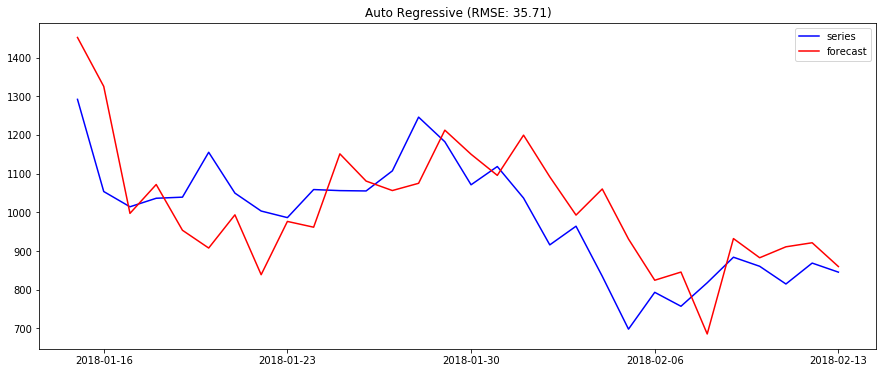

In [13]:
from statsmodels.tsa.ar_model import AR
yHat = []
maxLag = lookBack
for k in range(maxLag, len(sCoin) - lookAhead):
    subSeries = sCoin[k-maxLag:k+lookAhead]
    lenSubSeries = len(subSeries)
    model = AR(subSeries)
    modelFit = model.fit(maxLag=maxLag)
    y = modelFit.predict(start=lenSubSeries,
                         end=lenSubSeries+1,
                         dynamic=False)
    yHat.append(y.values[0])
yHat = pd.Series(yHat, index=sCoin.index[maxLag+lookAhead:])

# ignore the first value
plotFc("Auto Regressive", sCoin[maxLag+lookAhead:], yHat)